# Imports

In [38]:
import os
import h5py
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline

# Setup

In [12]:
# basePath = os.path.join('results', 'polish_rho_rho')
basePath = os.path.join('results', 'mo_fixed')

fromArchive = True

In [31]:
if fromArchive:
    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    tree = pickle.load(open(os.path.join(basePath, 'tree.pkl'), 'rb'))
    
    treeName = 'mul(sqrt(sqrt(rho)), rho)'
    entry = archive[treeName]
    tree.bestParams = entry.bestParams
    
    errors = entry.bestErrors
else:
    files = sorted(glob.glob(os.path.join(basePath, 'tree*')))
    intIndices = [int(s[s.find('tree')+5:s.find('.pkl')]) for s in files]

    argsort = np.argsort(intIndices)

    treeFile = np.array(files)[argsort][-1]
    tree = pickle.load(open(treeFile, 'rb'))

In [32]:
print('Tree:', tree)

Tree: mul(sqrt(rho), rho)


# Plotting

In [26]:
def plotSpline(x, y, bc):
    cs = CubicSpline(x, y, bc_type=((1, bc[0]), (1, bc[1])))
    
    plotX = np.linspace(x[0], x[-1], 100)
    plotY = cs(plotX)
    
    return plotX, plotY

In [27]:
splits = []

for svNode in tree.svNodes:
    for comp in svNode.components:
        splits.append(svNode.numParams[comp]+2)

In [28]:
splitParams = np.array_split(tree.bestParams, np.cumsum(splits)[:-1])

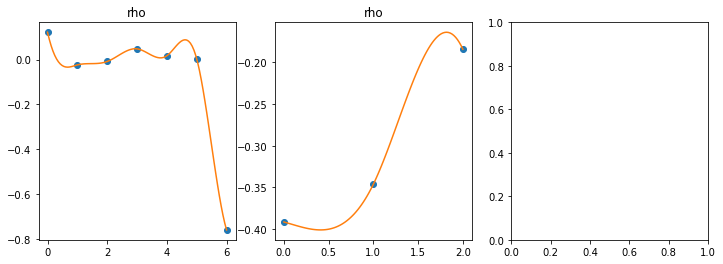

In [29]:
numRows = len(splitParams)//3 + 1

fig, axes = plt.subplots(numRows, 3, figsize=(12, 4*numRows))

for i, spline in enumerate(splitParams):
    y, bc = spline[:-2], spline[-2:]
    x = np.arange(len(y))
    
    plotX, plotY = plotSpline(x, y, bc)
    
    row = i//3
    col = i%3
    
    if numRows > 1:
        ax = axes[row][col]
    else:
        ax = axes[col]
    
    ax.plot(x, y, 'o')
    ax.plot(plotX, plotY)
    ax.set_title(tree.svNodes[i].description)

# Errors

In [48]:
with h5py.File('../svreg_data/mlearn/Mo/Mo.hdf5', 'r') as db:
        
    print(
        '{:>45} average errors || {:.6f} {:.6f}\n'.format(
            str(tree),
            np.average(errors[::2]),
            np.average(errors[1::2]),
        )
    )
    
    print(
        '{:>60} || {} {}'.format(
            'structName',
            '(eV/atom)',
            '(eV/A)'
        )
    )
    
    for i, structName in enumerate(sorted(db)):
        print(
            '{:>60} || {:.6f} {:.6f}'.format(
                structName,
                errors[2*i],
                errors[2*i+1]
            )
        )

                          mul(sqrt(rho), rho) average errors || 0.044520 0.375722

                                                  structName || (eV/atom) (eV/A)
                                        Ground_state_crystal || 0.000000 0.051103
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 0.029910 0.041121
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.056065 0.040372
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.077091 0.042918
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.091863 0.040386
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.097391 0.046941
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.035147 0.055489
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.160486 0.070082
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.029971 0.040508
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.056006 0.040337
                

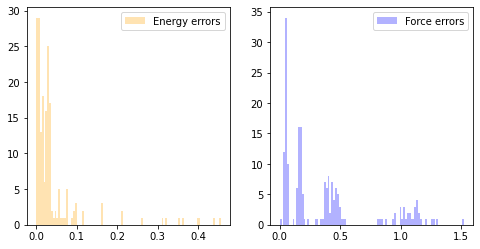

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(errors[::2] , bins=100, alpha=0.3, label='Energy errors', color='orange')
ax[1].hist(errors[1::2], bins=100, alpha=0.3, label='Force errors', color='blue')

ax[0].legend()
ax[1].legend()